In [ ]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Input, Lambda ,Dense ,Flatten , Dropout , GlobalAveragePooling2D

In [ ]:
#vgg 16 model
classifier_vgg16 = VGG16(input_shape= (224,224,3),include_top=False,weights='imagenet')
classifier_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#not train top layers
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [ ]:
classifier_vgg16.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
#adding extra layers for our class/images
main_model = classifier_vgg16.output
main_model = GlobalAveragePooling2D()(main_model)
main_model = Dense(2024,activation='relu')(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dense(1024,activation='relu')(main_model)
main_model = Dropout(0.5)(main_model)
main_model = Dense(180,activation='softmax')(main_model)

In [ ]:
#compiling
model = Model(inputs = classifier_vgg16.input , outputs = main_model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Part 2 - Fitting the CNN to the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#use the image data generator to import the images from the dataset
#data augmentation
train_datagen = ImageDataGenerator(rotation_range=5,
                                   rescale = False,
                                   shear_range = 0.2,
                                   fill_mode='reflect',
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
#makes sure you provide the same target as initialised for the image size
training_set = train_datagen.flow_from_directory('./left_dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('./left_dataset/test',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            class_mode='categorical',
                                            shuffle=False)

Found 150 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


In [ ]:
#fit the model
#it will take some time to train
nb_train_samples=150
nb_validation_samples=40
batch_size=64

history = model.fit_generator(training_set,
                              validation_data=test_set,
                              epochs=50,
                              steps_per_epoch=nb_train_samples // batch_size,
                              validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
2/2 [==============================] - 7s 4s/step - loss: 1.1734 - accuracy: 0.5312
Epoch 2/50
2/2 [==============================] - 7s 3s/step - loss: 1.0433 - accuracy: 0.6406
Epoch 3/50
2/2 [==============================] - 6s 3s/step - loss: 1.0613 - accuracy: 0.5556
Epoch 4/50
2/2 [==============================] - 6s 4s/step - loss: 1.0506 - accuracy: 0.6481
Epoch 5/50
2/2 [==============================] - 7s 3s/step - loss: 1.0736 - accuracy: 0.5741
Epoch 6/50
2/2 [==============================] - 8s 4s/step - loss: 0.9765 - accuracy: 0.5625
Epoch 7/50
2/2 [==============================] - 8s 4s/step - loss: 1.2222 - accuracy: 0.4531
Epoch 8/50
2/2 [==============================] - 6s 3s/step - loss: 1.0078 - accuracy: 0.6094
Epoch 9/50
2/2 [==============================] - 6s 2s/step - loss: 0.8513 - accuracy: 0.6667
Epoch 10/50
2/2 [==============================] - 7s 3s/step - loss: 1.1626 - accuracy: 0.5625
Epoch 11/50
2/2 [==============================] 

In [ ]:
model.save("modelL.h5")

In [ ]:
pip install matplotlib

     |████████████████████████████████| 11.6 MB 1.2 MB/s eta 0:00:01
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
     |████████████████████████████████| 1.2 MB 3.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


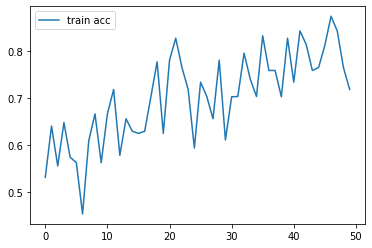

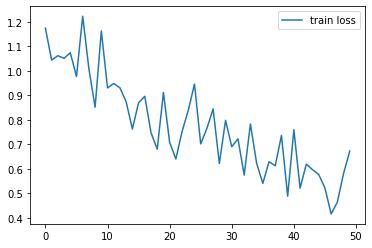

In [ ]:
#PLOTTING accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'] , label = 'train acc')
plt.legend()
plt.show()

#PLOTTING loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , label = 'train loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
classifier = load_model('modelL.h5')

In [ ]:
from PIL import Image 
import base64
from io import BytesIO
import json
import random
import cv2
import numpy as np

In [ ]:
# # Loading the cascades
# face_cascade = cv2.CascadeClassifier('G:/projects/face recognition transfer learning/haarcascade_frontalface_default.xml')

# def face_extractor(img):
#     # Function detects faces and returns the cropped face
#     # If no face detected, it returns the input image
    
#     #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
#     if faces is ():
#         return None
    
#     # Crop all faces found
#     for (x,y,w,h) in faces:
#         cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
#         cropped_face = img[y:y+h, x:x+w]

#     return cropped_face

# # Doing some Face Recognition with the webcam
# video_capture = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
# while True:
#     _, frame = video_capture.read()
    
#     face=face_extractor(frame)
#     if type(face) is np.ndarray:
#         face = cv2.resize(face, (224, 224))
#         im = Image.fromarray(face, 'RGB')
#         img_array = np.array(im)            
#         img_array = np.expand_dims(img_array, axis=0)
#         pred = classifier.predict(img_array)
#         print(pred)
                     
#         name="None matching"
        
#         if(pred[0][0]>0.5):
#             name='ben_afflek'
#         if(pred[0][1]>0.5):
#             name='elton_john'
#         if(pred[0][2]>0.5):
#             name='jerry_seinfeld'
#         if(pred[0][3]>0.5):
#             name='madonna'
#         if(pred[0][4]>0.5):
#             name='mindy_kaling'
        
#         cv2.putText(frame,name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
#     else:
#         cv2.putText(frame,"There is no face in the frame", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
#     #cv2.imshow('Video', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# video_capture.release()
# cv2.destroyAllWindows()

In [ ]:
import numpy as np
model_L = load_model('modelL.h5')
testimage= image.load_img('./left_dataset/test/P3/C3_S1_I13.jpg',target_size=(224,224,3))
testimage= image.img_to_array(timage)
testimg= np.expand_dims(testimage,axis=0)
testimg.shape
result= model_L.predict(testimg)
result

array([[1.5502374e-37, 0.0000000e+00, 1.0000000e+00, 3.3429520e-18,
        1.0683349e-37, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)